Last Modifed:July 23, 2019

Description: This notebook builds a simple neural network and trains it. The data used is from a Kaggle dataset (Intel Image Classification).

This one uses pytorch.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import time
import os

print('pytorch version: ',torch.__version__)

pytorch version:  1.1.0


Declare path to the data.

In [2]:
training_path='seg_train'
test_path='seg_test'

In [3]:
class_dict={}
for i in os.listdir(training_path):
    class_dict[i]=os.listdir(training_path+'/'+i)

In [4]:
img_list=[]
class_list=[]
classes=[]
dr=[]

In [5]:
for ii in class_dict:
    classes.append(ii)

In [6]:
for ii,val in enumerate(class_dict.values()):
    for img in val :
        img_list.append(img)
        class_list.append(classes[ii])

In [7]:
for ii in range(len(class_list)):
    dr.append(training_path+'/'+class_list[ii]+'/'+img_list[ii])

Check number of training images.

In [8]:
len(class_list)

14034

Next I wanted to set a number of transforms to apply to the images. Namely, resize all images to 150x150, randomly flip them vertically and horizonatally, and random rotations up to 25 degrees. These transformations were applied to the training set, but the test set was only resized.

In [9]:
train_tf=transforms.Compose([transforms.Resize((150,150)),
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomVerticalFlip(),
                             transforms.RandomAffine(25),
                             transforms.ToTensor()])

test_tf=transforms.Compose([transforms.Resize((150,150)),
                            transforms.ToTensor()])

The data is packaged into a dataset then loaded as batches.

In [10]:
train_dataset=datasets.ImageFolder(root=training_path, transform=train_tf)

test_dataset=datasets.ImageFolder(root=test_path, transform=test_tf)

In [11]:
train_load=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, drop_last=True, shuffle=True)      

test_load=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, drop_last=True, shuffle=False)

The neural network is then constructed as a class. The layers are made with torch.nn layers.

In [12]:
class myModel(nn.Module):
    def __init__(self):
        super(myModel,self).__init__()
        
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=2)
        self.relu=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1=nn.Linear(in_features=64*9*9, out_features=128)
        self.fc2=nn.Linear(in_features=128, out_features=64)
        self.droput=nn.Dropout(p=0.5)
        self.fc3=nn.Linear(in_features=64, out_features=len(classes)) 
        
    def forward(self,x):
        out=self.cnn1(x)
        out=self.relu(out)
        out=self.maxpool1(out)
        out=self.cnn2(out)
        out=self.relu(out)
        out=self.maxpool2(out)
        out=out.view(64,64*9*9)
        out=self.fc1(out)
        out=self.relu(out)
        out=self.fc2(out)
        out=self.relu(out)
        out=self.droput(out)
        out=self.fc3(out)
        return out

The model is then declared and the optimizer and loss are created.

In [13]:
model=myModel()

In [14]:
myOpt=torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn=nn.CrossEntropyLoss()

The training is done in a loop over a number of epochs, in this case 15.



In [15]:
t=time.time()

acc_list=[]
val_acc_list=[]

#Loop for n_epochs
for epoch in range(15):
    print('Epoch: ',epoch)
        
    running_loss = 0.0  
    total_train_loss = 0
    
    pred=[]
    true=[]
    
    for ii, data in enumerate(train_load, 0):
        
        #data, labels
        x,y=data
            
        #The data and labels need to be 'variables'
        x,y=Variable(x),Variable(y)
            
        myOpt.zero_grad()
            
        # have the model output predictions, then evaluate on those
        y_out=model(x)
        loss_size=loss_fn(y_out, y)
        loss_size.backward()
        myOpt.step()
            
        running_loss+=loss_size.data.item()
        total_train_loss+=loss_size.data.item()
        
        _,temp=torch.max(y_out, 1)
        pred+=(list(temp.numpy()))
        true+=(list(y.numpy()))
           
    print('Accuracy: ',accuracy_score(true,pred))
    acc_list.append(accuracy_score(true,pred))
         
        
    #check validation set (I named it test)
    total_val_loss = 0
    pred=[]
    true=[]
    for ii, data in enumerate(test_load, 0):
            
        x,y=data
            
        x,y=Variable(x), Variable(y)
            
        y_out_test=model(x)
        val_loss_size=loss_fn(y_out_test, y)
        total_val_loss+=val_loss_size.data.item()
        
        _,temp=torch.max(y_out_test, 1)
        pred+=(list(temp.numpy()))
        true+=(list(y.numpy()))
        
    print('Validation Accuracy: ',accuracy_score(true,pred))
    val_acc_list.append(accuracy_score(true,pred))    
        
    print('Validation Loss:',(total_val_loss/len(test_load)))
        
elapsed=time.time()-t

Epoch:  0
Accuracy:  0.421875
Validation Accuracy:  0.5475543478260869
Validation Loss: 1.1310222038756246
Epoch:  1
Accuracy:  0.5940353881278538
Validation Accuracy:  0.6226222826086957
Validation Loss: 0.9894237796897474
Epoch:  2
Accuracy:  0.6431221461187214
Validation Accuracy:  0.6453804347826086
Validation Loss: 0.9463684189578762
Epoch:  3
Accuracy:  0.6653824200913242
Validation Accuracy:  0.6623641304347826
Validation Loss: 0.9396719433691191
Epoch:  4
Accuracy:  0.677654109589041
Validation Accuracy:  0.6878396739130435
Validation Loss: 0.8772443403368411
Epoch:  5
Accuracy:  0.6927796803652968
Validation Accuracy:  0.7082201086956522
Validation Loss: 0.8111163743812105
Epoch:  6
Accuracy:  0.7118293378995434
Validation Accuracy:  0.7255434782608695
Validation Loss: 0.7850933458818041
Epoch:  7
Accuracy:  0.7191780821917808
Validation Accuracy:  0.7299592391304348
Validation Loss: 0.7759577638429144
Epoch:  8
Accuracy:  0.7338755707762558
Validation Accuracy:  0.75237771739

Plot the accuracy vs epoch.

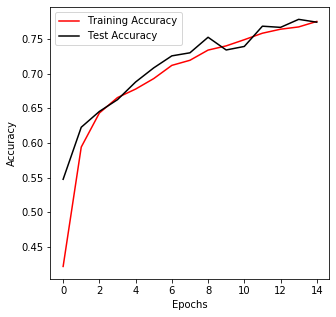

In [22]:
plt.figure(figsize=(5,5))
plt.plot(acc_list,'r',label='Training Accuracy')
plt.plot(val_acc_list,'k',label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Then test the trained model to evaluate performance.

In [17]:
pred=[]
true=[]

for ii, data in enumerate(test_load, 0):
            
        #Get inputs
        x, y=data
            
        #Wrap them in a Variable object
        x, y=Variable(x), Variable(y)
            
        #Forward pass
        y_out_test=model(x)
        
        _,temp=torch.max(y_out_test, 1)
        
        pred+=(list(temp.numpy()))
        true+=(list(y.numpy()))

A confusion matrix is very useful to see number of correct classifications and the incorrect ones all at once.

In [18]:
conf=confusion_matrix(true,pred)

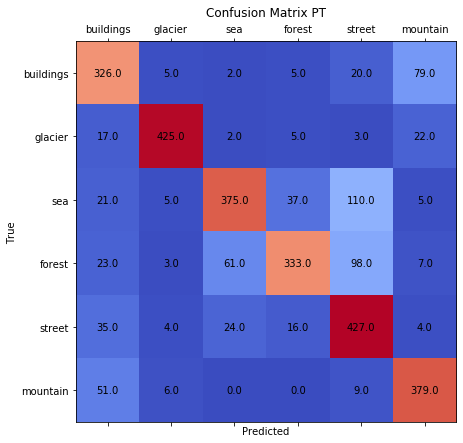

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(conf, cmap='coolwarm')
ax.set_xticklabels(['']+classes)
ax.set_yticklabels(['']+classes)
plt.title('Confusion Matrix PT')
plt.xlabel('Predicted')
plt.ylabel('True')

for (ii, jj), val in np.ndenumerate(conf):
    ax.text(jj, ii, '{:0.1f}'.format(val), ha='center', va='center')

plt.show()

I included a classification report in case more comparisons wanted to be made.

In [20]:
CR=classification_report(true,pred)

print(CR)

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       437
           1       0.95      0.90      0.92       474
           2       0.81      0.68      0.74       553
           3       0.84      0.63      0.72       525
           4       0.64      0.84      0.73       510
           5       0.76      0.85      0.81       445

    accuracy                           0.77      2944
   macro avg       0.78      0.77      0.77      2944
weighted avg       0.78      0.77      0.77      2944



Lastly, the accuracy is reported and the training time. These values are saved for comparison.

In [21]:
acc=accuracy_score(true,pred)

print('Training Time: ', elapsed)
print('Final Accuracy: ', acc)

np.save('PT',(elapsed,acc))

Training Time:  813.0522592067719
Final Accuracy:  0.7693614130434783
